In [1]:
import os, requests, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from scipy.stats import zscore
from umap import UMAP

c:\Users\rphan\Documents\GitHub\stringer-neuromatch\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def retrieve_data_orientation() -> np.array:
    """
    Retrieve Stringer et al. (2019) orientation data from OSF repository.

    Returns:
        dat (np.array): array of orientation data
    """
    fpath = "./data/stringer_orientations.npy"
    url = "https://osf.io/ny4ut/download"

    if not os.path.exists(fpath):
        try:
            r = requests.get(url)
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fpath, "wb") as fid:
                    fid.write(r.content)

    dat = np.load('./data/stringer_orientations.npy', allow_pickle=True).item()
    return dat


In [3]:
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
dat = retrieve_data_orientation()
cdepths = np.load('./data/all_depths.npy',allow_pickle=True)

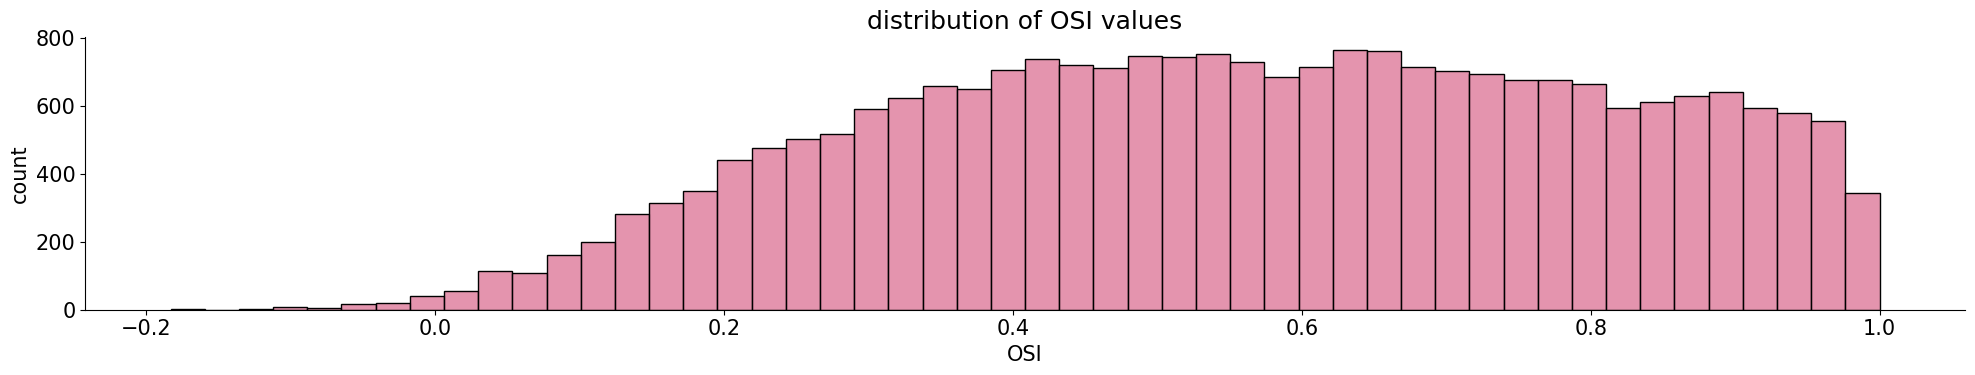

In [5]:
OSI_df = pd.read_csv('./data/OSI_values_1.csv', header=None).rename({ 0: 'OSI' }, axis=1)
sns.histplot(OSI_df['OSI'], bins=50, color='palevioletred')
plt.title('distribution of OSI values')
plt.xlabel('OSI')
plt.ylabel('count')
plt.show()

percentage of high OSI values: 59.07414472847514%


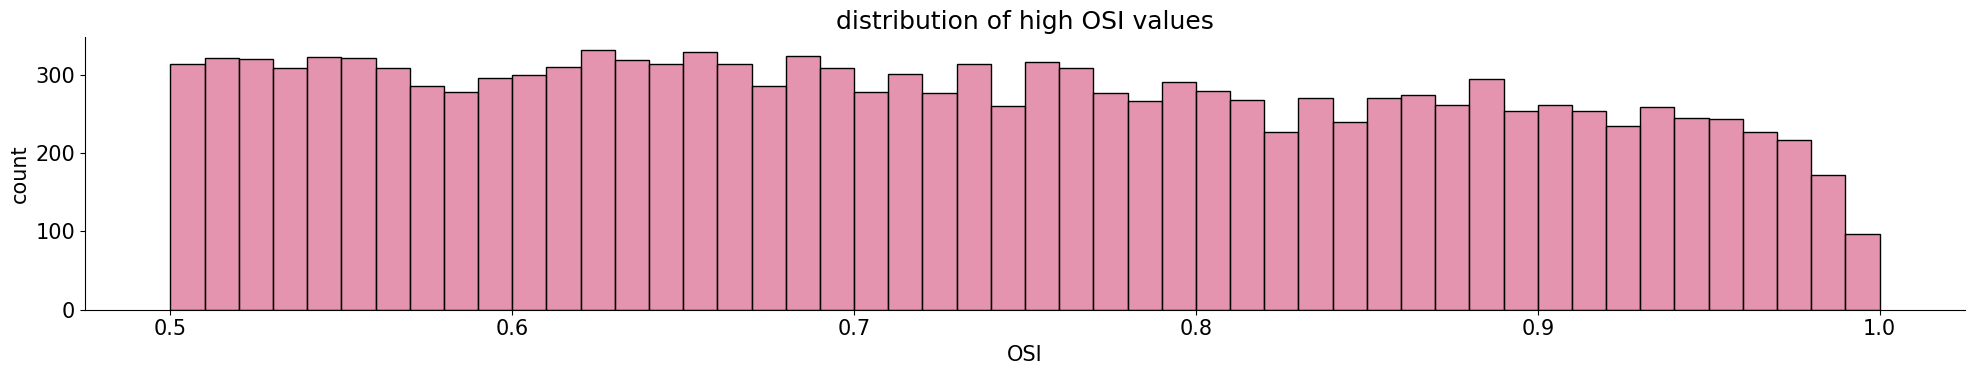

In [6]:
high_OSI_df = OSI_df[OSI_df['OSI'] >= 0.5]
print(f'percentage of high OSI values: {high_OSI_df.shape[0] / OSI_df.shape[0] * 100}%')
sns.histplot(high_OSI_df['OSI'], bins=50, color='palevioletred')
plt.title('distribution of high OSI values')
plt.xlabel('OSI')
plt.ylabel('count')
plt.show()

percentage of low OSI values: 40.92585527152487%


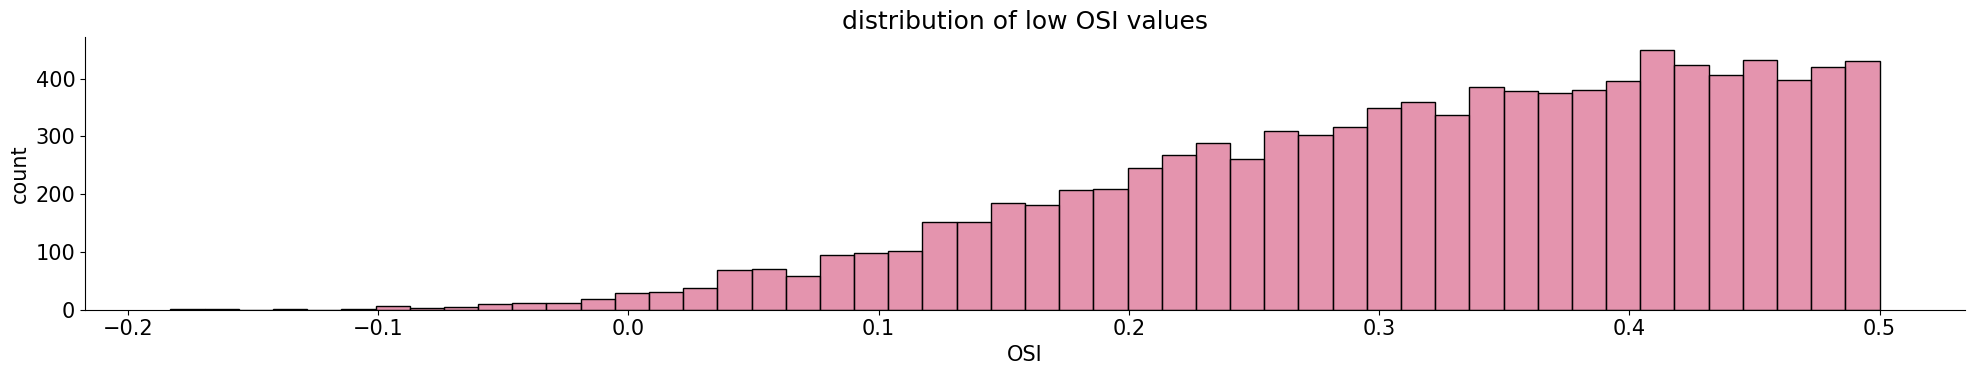

In [7]:
low_OSI_df = OSI_df[OSI_df['OSI'] < 0.5]
print(f'percentage of low OSI values: {low_OSI_df.shape[0] / OSI_df.shape[0] * 100}%')
sns.histplot(low_OSI_df['OSI'], bins=50, color='palevioletred')
plt.title('distribution of low OSI values')
plt.xlabel('OSI')
plt.ylabel('count')
plt.show()

In [8]:
from plotly import express as px

In [19]:
def plot_interactive_umap(sresp_data, istim_data, title: str, ncomp: int = 3):
    Z = zscore(sresp_data, axis=1)
    X = PCA(n_components=200).fit_transform(Z.T)

    xinit = 3 * zscore(X[:, :ncomp], axis=0)
    embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=25,
                metric='correlation', transform_seed=42).fit_transform(X)
    
    fig = px.scatter_3d(x=embed[:, 0], y=embed[:, 1], z=embed[:, 2], color=istim_data, title=title, width=800, height=800)
    # make the markers smaller
    fig.update_traces(marker=dict(size=2))
    fig.show()

In [20]:
def plot_umap(sresp_data, istim_data, title: str, ncomp: int = 3):
    Z = zscore(sresp_data, axis=1)
    X = PCA(n_components=200).fit_transform(Z.T)

    xinit = 3 * zscore(X[:, :ncomp], axis=0)
    embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=25,
                metric='correlation', transform_seed=42).fit_transform(X)
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    plt.title(title)
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2], c=istim_data, cmap='hsv', alpha=0.8)
    plt.show()

In [21]:
%%time

plot_interactive_umap(dat['sresp'], dat['istim'], 'UMAP decomposition of all neurons')

CPU times: total: 2min 50s
Wall time: 25.4 s


In [22]:
%%time
# plot umap for high OSI neurons
plot_interactive_umap(dat['sresp'][high_OSI_df.index], dat['istim'], 'UMAP decomposition of high OSI neurons')

CPU times: total: 1min 41s
Wall time: 14.1 s


In [23]:
%%time
# plot umap for low OSI neurons
plot_interactive_umap(dat['sresp'][low_OSI_df.index], dat['istim'], 'UMAP decomposition of low OSI neurons')

CPU times: total: 1min 44s
Wall time: 15.5 s
